# Analysis & Comparison 

## Libraries 

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Data set 

In [2]:
#file = 'Data/data.csv'
file = 'Data/new_dataset_clean.csv'
dataframe = pd.read_csv(file, error_bad_lines=False, sep=";")
df = dataframe.copy()
print("Data set's shape = ", df.shape) 
print("There is {} missing values in the target".format(df['Label'].isnull().sum()))

Data set's shape =  (43721, 2)
There is 0 missing values in the target


In [4]:
df.tail(7)

,Tweets,Label
43714,you're all niggers,1
43715,you're such a retard i hope you get type 2 dia...,1
43716,you's a muthaf***in lie right his tl is tr...,1
43717,you've gone and broke the wrong hea baby and ...,0
43718,young buck wanna eat dat nigguh like i aint fu...,1
43719,youu got wild bitches tellin you lies,1
43720,ruffled ntac eileen dahlia beautiful color c...,0


# Canonization : Lemmatization vs Stemming

### Number of Tokens per canonization method (100% of data set)

In [13]:
from DPreprocessing import canonization
nbr_lemmatized_tokens = len(canonization(df['Tweets'], method="lemmatization"))
nbr_stemmed_tokens = len(canonization(df['Tweets'], method="stemming"))

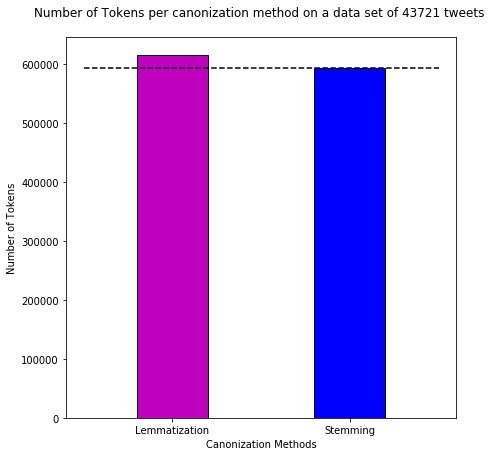

In [73]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(7,7))
methods = ["Lemmatization","Stemming"]
nbr_tokens = [nbr_lemmatized_tokens, nbr_stemmed_tokens]
plt.bar(methods, nbr_tokens, width=0.4, color=['m','b'], edgecolor='black')
plt.hlines(nbr_tokens[1], -0.5, 1.5, colors='k', linestyles='dashed')
plt.xlabel("Canonization Methods")
plt.ylabel("Number of Tokens")
plt.title("Number of Tokens per canonization method on a data set of {} tweets \n".format(df.shape[0]))
plt.show()

### Most frequent tokens after Lemmatization & Stemming (10'000 exp from data set)

In [5]:
%%time
from DPreprocessing import data_cleaning, canonization, stop_words, balanced_sample

data = balanced_sample(df,10000)
cleaned_data = data_cleaning(data)
lemmatized_tokens = stop_words(canonization(cleaned_data['Tweets'],method="lemmatization"))
stemmed_tokens = stop_words(canonization(cleaned_data['Tweets'],method="stemming"))

CPU times: user 1min 34s, sys: 6.66 s, total: 1min 41s
Wall time: 1min 41s


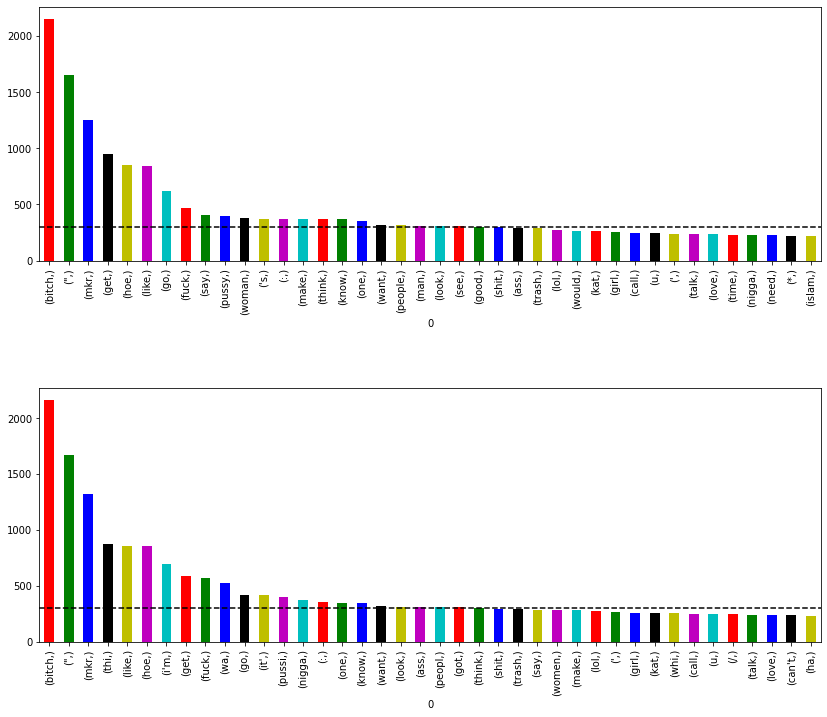

In [21]:
import matplotlib.pyplot as plt 

colors_list = list('rgbkymc')
fig, ax = plt.subplots(2,1, figsize=(14,9))

pd.DataFrame(lemmatized_tokens).value_counts()[:40].plot(kind='bar', color=colors_list, ax=ax[0])
ax[0].hlines(300, -0.5, 40, colors='k', linestyles='dashed')

pd.DataFrame(stemmed_tokens).value_counts()[:40].plot(kind='bar', color=colors_list, ax=ax[1])
ax[1].hlines(300, -0.5, 40, colors='k', linestyles='dashed')

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
plt.show()

### Evaluation of Lemmatization & Stemming (10'000 exp from data set)

In [37]:
%%time
from DPreprocessing import preprocessing 
from Models import support_vector_machine 

data = balanced_sample(df,10000)

# Lemmatization 
X_train, X_test, y_train, y_test = preprocessing(data, nbr_tokens=100, vectorizer="bow", canon="lemmatization")
f1_score_lemma = support_vector_machine(X_train, X_test, y_train, y_test, metric="f1score")
accuracy_lemma = support_vector_machine(X_train, X_test, y_train, y_test, metric="accuracy")

# Stemming 
X_train, X_test, y_train, y_test = preprocessing(data, nbr_tokens=100, vectorizer="tfidf", canon="stemming")
f1_score_stem = support_vector_machine(X_train, X_test, y_train, y_test, metric="f1score")
accuracy_stem = support_vector_machine(X_train, X_test, y_train, y_test, metric="accuracy")


>>> Copy data set
>>> Preprocessing start
>>> Data cleaned 
>>> Canonization done
>>> Vectorization done
>>> Split Data done 
>>> End of Preprocessing
>>> Copy data set
>>> Preprocessing start
>>> Data cleaned 
>>> Canonization done
>>> Vectorization done
>>> Split Data done 
>>> End of Preprocessing
CPU times: user 1min 19s, sys: 538 ms, total: 1min 20s
Wall time: 1min 20s


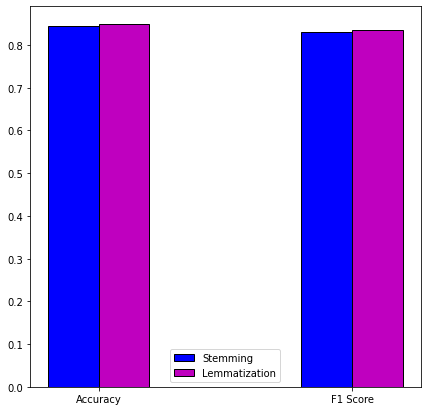

In [38]:
from Evaluations import metrics_graphic 

lemmatization_metrics = [accuracy_lemma,f1_score_lemma]
stemming_metrics = [accuracy_stem,f1_score_stem]

metrics_graphic(stemming_metrics, lemmatization_metrics)

## Tweets length 

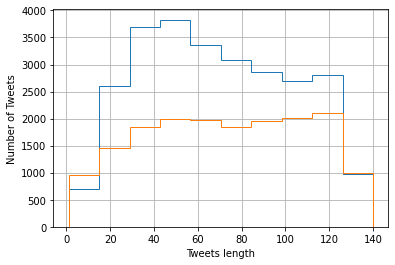

In [66]:
h = 'step'
df['Tweets'][df['Label']==1].str.len().hist(histtype=h)
df['Tweets'][df['Label']==0].str.len().hist(histtype=h)
plt.xlabel('Tweets length')
plt.ylabel('Number of Tweets')
plt.show()

In [51]:
# Build a function that returns the length of each tweet 
def len_tweets(tweets):
    pass 

## Shallow parsing (Chunking)

In [67]:
import spacy 
nlp = spacy.load('en_core_web_sm')

**Noun phrase extraction**

In [221]:
def tweet_noun_chunks(tweets):
    '''
        This function generates a list of noun chunks who's tokens are not in stopwords list 
    '''
    from nltk.corpus import stopwords
    
    tweets_noun_chunks = []
    for tweet in tweets:
        doc = nlp(tweet)
        for chunk in doc.noun_chunks: 
            if len(str(chunk).split())>1 and any(word in str(chunk).split() for word in stopwords.words('english'))==False:
                #print(">>>>> ", chunk) 
                tweets_noun_chunks.append(chunk.text.strip())
    return tweets_noun_chunks    

In [222]:
%%time
# noun chunks + stop words 
from DPreprocessing import stop_words 
tweet_noun_chunks = tweet_noun_chunks(cleaned_data['Tweets'])

CPU times: user 1min 9s, sys: 1.06 s, total: 1min 10s
Wall time: 1min 10s


<AxesSubplot:xlabel='0'>

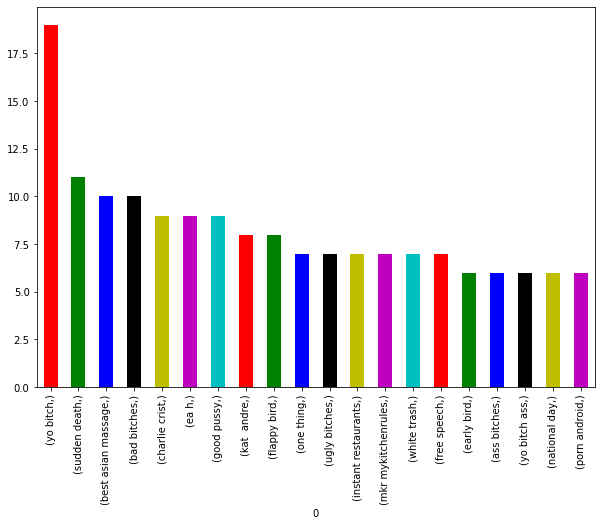

In [220]:
plt.figure(figsize=(10,7))
colors_list = list('rgbkymc')
pd.DataFrame(tweet_noun_chunks).value_counts()[:20].plot(kind='bar', color=colors_list)

**Verb phrases extraction**

## Named-Entity Recognition (NER)

In [229]:
def named_entity_recognition(tweets):    
    nlp = spacy.load('en_core_web_sm')
    bloc = []
    for tweet in tweets: 
        doc = nlp(tweet)
        for ent in doc.ents:
            bloc.append([ent.text, ent.label_])
    return bloc

In [234]:
%%time
ner = named_entity_recognition(cleaned_data['Tweets'])

CPU times: user 1min 31s, sys: 558 ms, total: 1min 31s
Wall time: 1min 32s


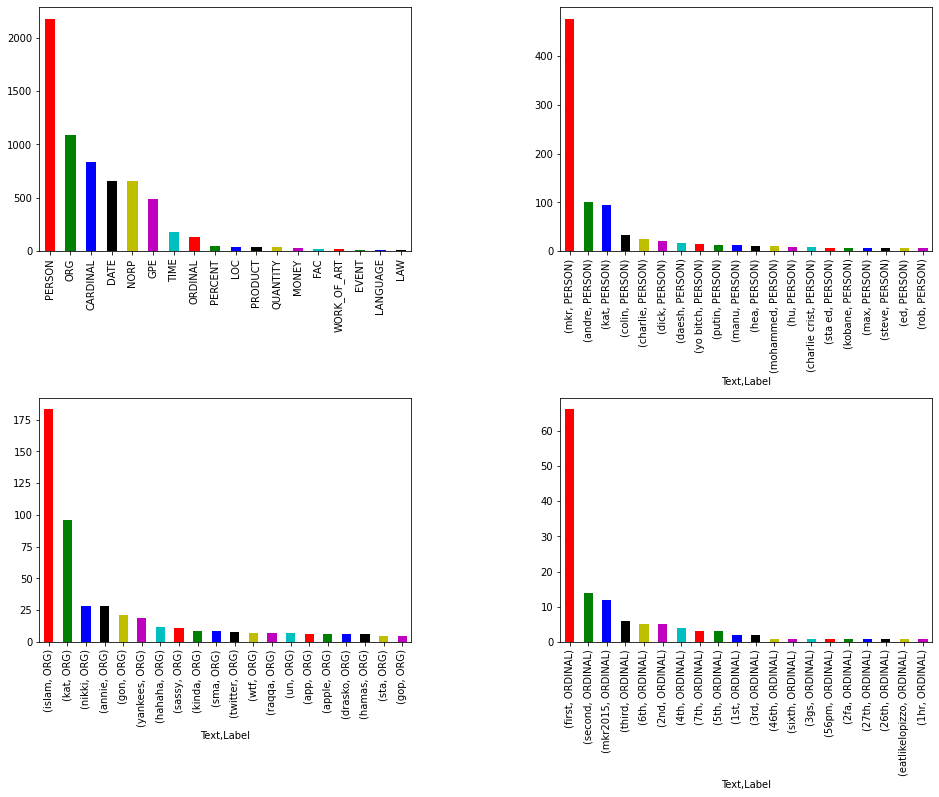

In [252]:
import matplotlib.pyplot as plt 

colors_list = list('rgbkymc')
NER = pd.DataFrame(ner,columns=['Text','Label'])

fig, ax = plt.subplots(2,2, figsize=(16,9))

# All labels 
NER['Label'].value_counts().plot(kind='bar', color=colors_list, ax=ax[0,0])

# Person
NER[NER['Label']=="PERSON"].value_counts()[:20].plot(kind='bar', color=colors_list, ax=ax[0,1])

# Organizations
NER[NER['Label']=="ORG"].value_counts()[:20].plot(kind='bar', color=colors_list, ax=ax[1,0])

# Ordinal 
NER[NER['Label']=="ORDINAL"].value_counts()[:20].plot(kind='bar', color=colors_list, ax=ax[1,1])


plt.subplots_adjust(top = 1.0, bottom=0.02, hspace=0.6, wspace=0.4)
plt.show()

## N-Gram Extraction 

In [257]:
def n_most_frequent_ngram(tweets, nbr_gram, nbr_mfg):
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer(max_features=1000, 
                                stop_words='english',
                                ngram_range = (nbr_gram,nbr_gram)
                                )
    vectorizer.fit(tweets)
    vocab = list(vectorizer.vocabulary_.keys())
    vector = vectorizer.transform(tweets).toarray()

    # Convert the matrix into a dataframe
    matrix = pd.DataFrame(vector, columns=vocab)
    
    return matrix 

**1-Gram**

In [263]:
onegram = n_most_frequent_ngram(tweets=cleaned_data['Tweets'][:100], nbr_gram=1, nbr_mfg=20)
#onegram.value_counts().plot(kind='bar')
onegram

,ready,tell,bitch,shut,da,fuck,lol,stress,away,come,...,crazy,cool,fags,violation,demands,beheaded,burned,pretty,prettier,titties
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**2-Gram**

In [ ]:
onegram = n_most_frequent_ngram(tweets=cleaned_data['Tweets'][:100], nbr_gram=2, nbr_mfg=20)
onegram.plot(kind='bar')

**3-Gram**

In [ ]:
onegram = n_most_frequent_ngram(tweets=cleaned_data['Tweets'][:100], nbr_gram=3, nbr_mfg=20)
onegram.plot(kind='bar')

## Polarity 